# CODEATHON 2: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](http://faculty.virginia.edu/lazzara/images/UVAgrounds.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 50 points for this codeathon plus 10 bonus points if (1) your classifier performs exceed 95% accuracy OR you try at least 3 different architectures and able to analyze their performance.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_2.ipynb

Best of luck, and have fun! 

# Load Packages

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49)
tf.random.set_seed(49)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [ ]:
# Download dataset from Firebase
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

In [ ]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

In [27]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 49,
    image_size= (img_height, img_width),
    batch_size = batch_size,
)

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 49,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


In [5]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

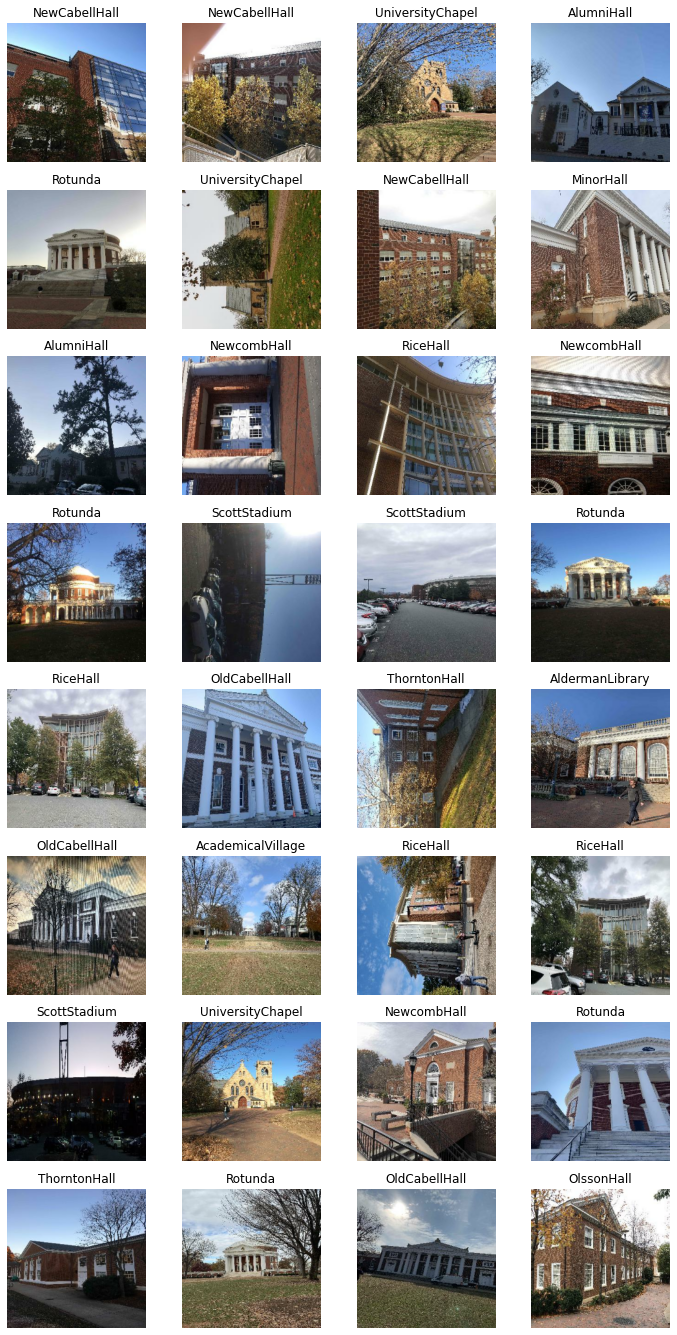

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture OR re-use any of the exising frameworks. 

Best of luck!

# Xception

In [85]:
from keras.preprocessing.image import ImageDataGenerator

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')

train_generator = train_datagen.flow_from_directory(directory=data_dir, target_size=(299,299), shuffle=False, classes=class_names, batch_size = batch_size, class_mode='categorical')
                                     
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(directory=data_dir, target_size=(299,299), shuffle=False, classes=class_names, batch_size = batch_size, class_mode='sparse')

Found 14086 images belonging to 18 classes.
Found 14086 images belonging to 18 classes.


In [36]:
# YOUR CODE STARTS HERE
from keras.applications.inception_v3 import InceptionV3
n_classes = len(class_names)

base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(512, activation="relu")(avg)
output = keras.layers.Dense(512, activation="relu")(output)
output = keras.layers.Dense(n_classes, activation="softmax")(output)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [155]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [9]:
train_size = 11429

In [40]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=.00009),metrics=["accuracy"])


epoch_size = 15
train_steps_per_epoch = train_size / batch_size 
val_steps_per_epoch = .25 * train_steps_per_epoch

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=epoch_size, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/15
358/357 [==============================] - 273s 762ms/step - loss: 1.4436 - accuracy: 0.5690 - val_loss: 1.8494 - val_accuracy: 0.4514
Epoch 2/15
358/357 [==============================] - 275s 767ms/step - loss: 1.3022 - accuracy: 0.6082 - val_loss: 1.4705 - val_accuracy: 0.5625
Epoch 3/15
358/357 [==============================] - 274s 765ms/step - loss: 1.2388 - accuracy: 0.6311 - val_loss: 1.3414 - val_accuracy: 0.5951
Epoch 4/15
358/357 [==============================] - 274s 764ms/step - loss: 1.1932 - accuracy: 0.6469 - val_loss: 1.2680 - val_accuracy: 0.6125
Epoch 5/15
358/357 [==============================] - 272s 759ms/step - loss: 1.1529 - accuracy: 0.6572 - val_loss: 1.2724 - val_accuracy: 0.6122
Epoch 6/15
358/357 [==============================] - 274s 766ms/step - loss: 1.0877 - accuracy: 0.6793 - val_loss: 1.2121 - val_accuracy: 0.6399
Epoch 7/15
358/357 [==============================] - 274s 765ms/step - loss: 1.0476 - accuracy: 0.6914 - val_loss: 1.1071 -

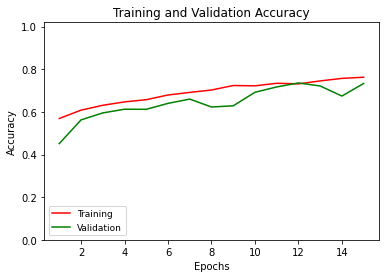

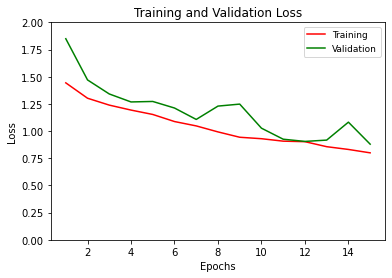

In [148]:
from scipy.interpolate import interp1d
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(acc)

plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y1 = np.array(val_acc)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(loss)

plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y1 = np.array(val_loss)


plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.show()

In [149]:
model.load_weights('/tmp/checkpoint')

In [150]:
for layer in base_model.layers:
    layer.trainable = True


model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr = 0.00001, momentum=0.9),metrics=["accuracy"])


history = model.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=5, verbose=1)

Epoch 1/5
358/357 [==============================] - 262s 731ms/step - loss: 3.2521 - accuracy: 0.0965 - val_loss: 2.0876 - val_accuracy: 0.5326
Epoch 2/5
358/357 [==============================] - 261s 729ms/step - loss: 3.0484 - accuracy: 0.0998 - val_loss: 2.4660 - val_accuracy: 0.4639
Epoch 3/5
358/357 [==============================] - 261s 728ms/step - loss: 2.9526 - accuracy: 0.1025 - val_loss: 2.5638 - val_accuracy: 0.4497
Epoch 4/5
358/357 [==============================] - 260s 728ms/step - loss: 2.8888 - accuracy: 0.1018 - val_loss: 2.6123 - val_accuracy: 0.4451
Epoch 5/5
358/357 [==============================] - 260s 727ms/step - loss: 2.8572 - accuracy: 0.1032 - val_loss: 2.6360 - val_accuracy: 0.4462


# InceptionV3

In [46]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
out = base_inception.output
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(512, activation='relu')(out)
out = keras.layers.Dense(512, activation='relu')(out)
predictions = keras.layers.Dense(n_classes, activation='softmax')(out)

InceptionModel = keras.models.Model(inputs=base_inception.input, outputs=predictions)

In [156]:
InceptionModel.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 149, 149, 32) 96          conv2d_114[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_114[0][0]    
______________________________________________________________________________________

In [116]:
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
InceptionModel.compile(keras.optimizers.Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

InceptionHistory = InceptionModel.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=epoch_size, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/15
358/357 [==============================] - 233s 652ms/step - loss: 1.6180 - accuracy: 0.5118 - val_loss: 2.0412 - val_accuracy: 0.3712
Epoch 2/15
358/357 [==============================] - 233s 651ms/step - loss: 1.4364 - accuracy: 0.5679 - val_loss: 1.4056 - val_accuracy: 0.5826
Epoch 3/15
358/357 [==============================] - 233s 651ms/step - loss: 1.4091 - accuracy: 0.5718 - val_loss: 1.2715 - val_accuracy: 0.6476
Epoch 4/15
358/357 [==============================] - 231s 646ms/step - loss: 1.3053 - accuracy: 0.6116 - val_loss: 1.3539 - val_accuracy: 0.5826
Epoch 5/15
358/357 [==============================] - 233s 651ms/step - loss: 1.2582 - accuracy: 0.6253 - val_loss: 2.0884 - val_accuracy: 0.4288
Epoch 6/15
358/357 [==============================] - 233s 651ms/step - loss: 1.2194 - accuracy: 0.6313 - val_loss: 1.5510 - val_accuracy: 0.5476
Epoch 7/15
358/357 [==============================] - 232s 648ms/step - loss: 1.1559 - accuracy: 0.6487 - val_loss: 1.2032 -

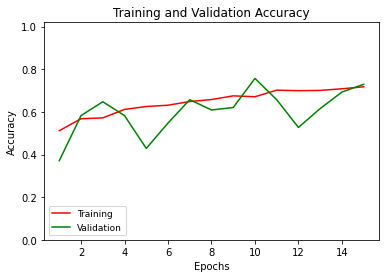

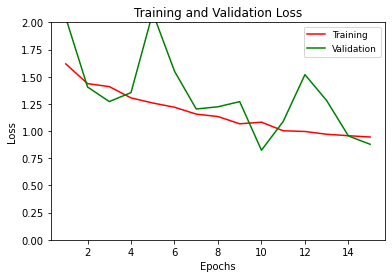

In [151]:
acc = InceptionHistory.history['accuracy']
val_acc = InceptionHistory.history['val_accuracy']
loss = InceptionHistory.history['loss']
val_loss = InceptionHistory.history['val_loss']

x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(acc)

plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y1 = np.array(val_acc)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(loss)

plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y1 = np.array(val_loss)


plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.show()

# VGG19

In [123]:
train_generator = train_datagen.flow_from_directory(directory=data_dir, target_size=(224,224), shuffle=False, classes=class_names, batch_size = batch_size)
val_generator = val_datagen.flow_from_directory(directory=data_dir, target_size=(224,224), shuffle=False, classes=class_names, batch_size = batch_size)

vgg19_model = keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape=(224, 224, 3))
x = vgg19_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(n_classes, activation = 'softmax')(x)
vgg19Model = keras.models.Model(inputs = vgg19_model.input, outputs = predictions)

Found 14086 images belonging to 18 classes.
Found 14086 images belonging to 18 classes.


In [157]:
vgg19Model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [127]:
for layer in vgg19_model.layers:
    layer.trainable = False
    
# Compile 
vgg19Model.compile(optimizer=keras.optimizers.Nadam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

vgg19History = vgg19Model.fit(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=5, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/5
358/357 [==============================] - 160s 446ms/step - loss: 2.3282 - accuracy: 0.3030 - val_loss: 2.8326 - val_accuracy: 0.0347
Epoch 2/5
358/357 [==============================] - 159s 445ms/step - loss: 2.2824 - accuracy: 0.3367 - val_loss: 2.8513 - val_accuracy: 0.0021
Epoch 3/5
358/357 [==============================] - 160s 446ms/step - loss: 2.2804 - accuracy: 0.3204 - val_loss: 2.8280 - val_accuracy: 0.0170
Epoch 4/5
358/357 [==============================] - 160s 446ms/step - loss: 2.2340 - accuracy: 0.3262 - val_loss: 2.5559 - val_accuracy: 0.1559
Epoch 5/5
358/357 [==============================] - 160s 446ms/step - loss: 2.2123 - accuracy: 0.3489 - val_loss: 2.6486 - val_accuracy: 0.0493


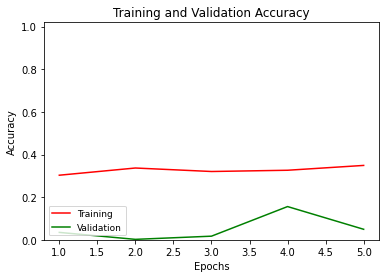

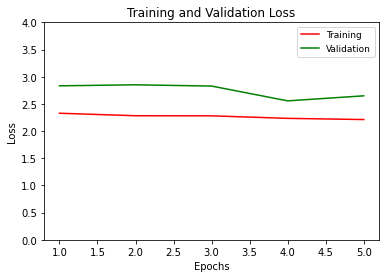

In [154]:
acc = vgg19History.history['accuracy']
val_acc = vgg19History.history['val_accuracy']
loss = vgg19History.history['loss']
val_loss = vgg19History.history['val_loss']

x = np.array([1,2,3,4,5])
y = np.array(acc)

plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array([1,2,3,4,5])
y1 = np.array(val_acc)

plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array([1,2,3,4,5])
y = np.array(loss)

plt.plot(x, y, 'r-', label = 'Training')

x1 = np.array([1,2,3,4,5])
y1 = np.array(val_loss)


plt.plot(x1, y1, 'g-', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.show()

# Results and Conclusions

In an attempt to build an image recognition system to classify different buildlings/landmarks on Grounds, I used three different ImageNet winning architectures with transfer learning to train my own models. The models I tried were Xception, InceptionV3, and VGG19. The process I used for transfer learning was as follows:


1.   Get the preexisting model architecture, and use the weights that were used for the ImageNet competition. Only include the pretrained input and hidden layers.
2.   Add our own pooling and dense output layers. Use softmax activation for the output since we are solving a classification problem.
3.   Freeze the pretrained layers so that we can train only the top layers that we added.
4. Unfreeze all layers and train again with a very small learning rate so that the pre-trained weights are not damaged.

To process the data, I used an ImageDataGenerator. This allowed me to rotate, shift, and flip the training images. It also allowed me to rescale each image so that it used RGB coefficients of floats between 0 and 1 instead of integers between 0 and 255, making data processing easier for the models. Image augmentation allowed me to essentially get more training data per class. I used image sizes of (299,299) for both Xception and InceptionV3 since they were pretrained on images of this size. I used (224,244) for VGG19 for the same reason. Additionally, I was able to convert the labels to one hot encoded labels using the data generator.

For each model I tested various top layers to add to the pretrained base model. Through testing I found that using a single global average pooling layer followed by multiple dense layers with relu activation, and a final dense with softmax performed the best. I also tried multiple compilers, but found that adam and nadam performed better than stochastic gradient descent and rmsprop in general. For both adam and nadam I found that using a low learning rate performed well. I tested learning rates from .00001 all the way to .01, but found that learning rates around .0001 performed the best. I used categorical cross entropy as my loss function since my labels were one hot encoded.

One of the biggest challenges I faced was the training time. To get accurate results I needed to have a large number of epochs and training steps per epoch. As a result, training each model took a long time, so experimenting with different hyperparamaters, compilers, and top layers was not as easy as I anticipated, and I was not able to test as many combinations as I wanted to. If I had more time, I definitely would have kept experimenting with all of these to try and improve my validation accuracy.

For each model, I plotted the training and validation loss and accuracy over Epoch number. From these graphs, it is clear to see that these values jumped around, and did not necessarily improve with each epoch. The loss and accuracy from one epoch to the next was very inconsistent and unpredictable, sometimes increasing while other times decreasing.

Based on the above results, it appears that using InceptionV3 as the pretrained model for transfer learning worked the best for this dataset. It produced the highest validation accuracy out of all three models, with a score of 75.69% during its 10th epoch. My Xception model performed very similarly though, with its highest validation accuracy being 73.58%. Unfortunately, I was not able to get a succesful VGG19 model working in time. Once again, I tried various combinations of learning rates, top layers, and compilers, but I was not able to find a combination that produced high validation accuracies. I would need to spend more time trying different combinations to improve this model.

You may notice that I did not include step 4 (fine tuning) for all three models. I tried this step for all the models, and with various configurations of hyperparameters, top layers, and compilers. Unfortunately, I was not able to find much success, and was not able to improve my validation scores significantly. This may be due to overfitting. As a result, I did not include this step for all models, but left the first one as an example of how I did this. I also used callbacks in order to save the layer weights that resulted in the highest validation accuracy, and used these weights before performing step 4 of transfer learning. I am unsure if I used this functionality correctly or not, as it did not seem to improve my fine tuning.

Overall, I learned a lot from this codeathon and now have a much better understanding of the transfer learning process. I now have practice picking hyperparameters, top layers, and compilers for transfer learning. I need more practice of this in order to improve my skills and be able to train models that produce better results.